<a href="https://colab.research.google.com/github/tifat58/PET-2020/blob/master/model_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import random
import torchvision.transforms as transforms

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
def weight_inits(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

In [4]:
def train_model(model, criterion, optimizer, data_loader, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in data_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
    #         else:
                
    #             model.eval()   # Set model to evaluate mode
                
    #             running_loss = 0.0
    #             running_corrects = 0
                
    #             for data in test_loader:
    #                 inputs, labels, idx = data
    #                 inputs = inputs.to(device)
    #                 labels = labels.to(device)
    #                 optimizer.zero_grad()
    #                 with torch.set_grad_enabled(False):
    #                     outputs = model(inputs)
    #                     _, preds = torch.max(outputs, 1)
                        
    #                     loss = criterion(outputs, labels)
                
    #                 running_loss += loss.item() * inputs.size(0)
    #                 running_corrects += torch.sum(preds == labels.data)
                
    #             epoch_loss = running_loss / test_size
    #             epoch_acc = running_corrects.double() / test_size
                
    #             print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
    #             if epoch_acc > best_acc:
    #                 best_acc = epoch_acc
    #                 best_model_wts = copy.deepcopy(model.state_dict())


    #     print()

    # time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    # # load best model weights
    # model.load_state_dict(best_model_wts)
    # return model, best_acc

In [5]:
def test_model(model, criterion, optimizer, data_loader):
    model.eval()   # Set model to evaluate mode
                
    running_loss = 0.0
    running_corrects = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_size
    epoch_acc = running_corrects.double() / test_size

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.5), (0.5))
     ])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False, num_workers=2)



Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...

Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [9]:
train_size = len(train_dataset)
test_size = len(test_dataset)
# net = torch.load('LeNet_5_class_pretrained_model.tar')
net = LeNet()
# net.apply(weight_inits)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer_ft, trainloader, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.6587 Acc: 0.7550
Epoch 1/9
----------
Train Loss: 0.4127 Acc: 0.8504
Epoch 2/9
----------
Train Loss: 0.3509 Acc: 0.8720
Epoch 3/9
----------
Train Loss: 0.3163 Acc: 0.8846
Epoch 4/9
----------
Train Loss: 0.2943 Acc: 0.8913
Epoch 5/9
----------
Train Loss: 0.2739 Acc: 0.8997
Epoch 6/9
----------
Train Loss: 0.2575 Acc: 0.9043
Epoch 7/9
----------
Train Loss: 0.2186 Acc: 0.9189
Epoch 8/9
----------
Train Loss: 0.2110 Acc: 0.9218
Epoch 9/9
----------
Train Loss: 0.2071 Acc: 0.9233


In [10]:
test_model(net, criterion, optimizer_ft, testloader)

Val Loss: 0.2744 Acc: 0.8995


In [11]:
def image_train(x, y, optimizer, model, epoch=1000):
    model.eval()
    
    for i in range(epoch):
        optimizer.zero_grad()
        logits = model(x)
        
        prob = torch.softmax(logits, -1)
        loss = y * prob.log()
        loss = - loss.sum(-1).mean()
        
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('loss', loss.item())
            
    print("Image training finished...")
    x = torch.tanh(x)
    return x,y

In [12]:
y = torch.FloatTensor([0.0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
x = torch.randn((1, 1, 28, 28), requires_grad=True)
optimizer = optim.Adam([x], lr=0.001)
images, labels = image_train(x, y, optimizer, net, 1000)

loss 32.715232849121094
loss 10.114593505859375
loss 0.17807050049304962
loss 0.043759435415267944
loss 0.02368350699543953
loss 0.015464171767234802
loss 0.01118827797472477
loss 0.00858175940811634
loss 0.006866791285574436
loss 0.005642687901854515
Image training finished...


(1, 1, 28, 28)


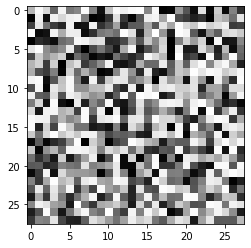

In [13]:
pic = images.detach().numpy()
print(pic.shape)
pic_1 = pic[0,0,:,:]
plt.imshow(pic_1, cmap='Greys', interpolation='nearest')

In [14]:
y_pred = net(images)
y_pred

tensor([[ -6.5461,  -1.7785, -15.6413,  -5.3755, -11.2720,  -3.1727,  -3.3173,
         -22.7896,  -4.5392, -16.3000]], grad_fn=<AddmmBackward>)